In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler

# importing the dataset

In [67]:
#import dataset
ds=pd.read_csv('C:/Users/nebiy/Documents/Dataset/datasets/Reviews.csv')

In [68]:
ds.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# EDA

In [69]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [70]:
ds.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [71]:
ds=ds.dropna(how='any')

In [72]:
ds.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [73]:
#ds[ds['UserId']]

In [74]:
ds.drop(['ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Summary','Text'],axis=1,inplace=True)

In [75]:
ds['Time'].value_counts()

Time
1350345600    1143
1322179200    1088
1322438400    1070
1346889600    1018
1344211200     989
              ... 
1095638400       1
1102636800       1
1080259200       1
1087689600       1
1069718400       1
Name: count, Length: 3168, dtype: int64

In [76]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568401 entries, 0 to 568453
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         568401 non-null  int64 
 1   ProductId  568401 non-null  object
 2   UserId     568401 non-null  object
 3   Score      568401 non-null  int64 
 4   Time       568401 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 26.0+ MB


# Encoding the features

In [77]:
object_encoders={}
columns=['ProductId','UserId']
for col in columns:
    le=LabelEncoder()
    ds[col]=le.fit_transform(ds[col])
    #storing the feature values and its encoded values
    object_encoders[col]=le

# lets make more features:
    * day of the week
    * month
    * time of the day(Hour)

In [78]:
#change the time stamp into datatime
ds['Time']=pd.to_datetime(ds['Time'],unit='s',utc=True)
ds['Time']=ds['Time'].dt.tz_convert('America/New_York')

In [79]:
ds.head()

,Id,ProductId,UserId,Score,Time
0,1,27619,188633,5,2011-04-26 20:00:00-04:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00


In [80]:
ds.head()

,Id,ProductId,UserId,Score,Time
0,1,27619,188633,5,2011-04-26 20:00:00-04:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00


In [81]:
#year
ds['year']=ds['Time'].dt.year
#month
ds['month']=ds['Time'].dt.month
#week
ds['day_of_week']=ds['Time'].dt.dayofweek
#hour
ds['hour']=ds['Time'].dt.time

In [82]:
ds.head()

,Id,ProductId,UserId,Score,Time,year,month,day_of_week,hour
0,1,27619,188633,5,2011-04-26 20:00:00-04:00,2011,4,1,20:00:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00,2012,9,3,20:00:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00,2008,8,6,20:00:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00,2011,6,6,20:00:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00,2012,10,5,20:00:00


In [83]:
ds.isnull().sum()

Id             0
ProductId      0
UserId         0
Score          0
Time           0
year           0
month          0
day_of_week    0
hour           0
dtype: int64

In [84]:
#droping the time column
clean_data=ds.drop(['Time'],axis=1)

In [85]:
#dropign the ID
clean_data.drop(['Id'],axis=1,inplace=True)

In [86]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568401 entries, 0 to 568453
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductId    568401 non-null  int32 
 1   UserId       568401 non-null  int32 
 2   Score        568401 non-null  int64 
 3   year         568401 non-null  int32 
 4   month        568401 non-null  int32 
 5   day_of_week  568401 non-null  int32 
 6   hour         568401 non-null  object
dtypes: int32(5), int64(1), object(1)
memory usage: 23.9+ MB


In [87]:
#convert the hour feature into int
clean_data['hour']=clean_data['hour'].apply(lambda x:x.hour )

# lets add another feature:
        * Name of the feature is: recomended
        * the feature if gonna be boolean
        * we are gonna assign it True if its equal or greater than 3 : False other wise

In [88]:
clean_data['Recomended']=clean_data['Score']>=3

In [89]:
clean_data.columns

Index(['ProductId', 'UserId', 'Score', 'year', 'month', 'day_of_week', 'hour',
       'Recomended'],
      dtype='object')

## droping the 'Rate'---> Score

In [90]:
clean_data.drop(['Score'],axis=1,inplace=True)

# mapping features

In [91]:
clean_data['year'].value_counts()

year
2012    198050
2011    163536
2010     86088
2009     55403
2008     34144
2007     22333
2006      6686
2005      1344
2004       560
2003       133
2002        73
2000        32
2001        13
1999         6
Name: count, dtype: int64

In [92]:
def mapping_function_year(year):
    return year-1999

In [93]:
#clone=clean_data.copy()

In [94]:
clean_data['year']=clean_data['year'].apply(mapping_function_year)

# mapping hour

In [95]:
def mapping_function_hour(hour):
    return hour-19

In [96]:
clean_data['hour'].value_counts()

hour
20    382504
19    185897
Name: count, dtype: int64

In [97]:
clean_data['hour']=clean_data['hour'].apply(mapping_function_hour)

In [98]:
clean_data.head()

,ProductId,UserId,year,month,day_of_week,hour,Recomended
0,27619,188633,12,4,1,1,True
1,72383,25104,13,9,3,1,False
2,15267,210468,9,8,6,1,True
3,19718,152622,12,6,6,1,False
4,69007,57800,13,10,5,1,True


In [99]:
# scaler=MinMaxScaler()

# columns_to_scale=['year','month','hour','day_of_week']
# clean_data[columns_to_scale]=scaler.fit_transform(clean_data[columns_to_scale])

In [298]:
# lets change the boolean into number
clean_data['Recomended']=clean_data['Recomended'].astype(int)

# split into train and test

In [299]:
#split into train and test
train,test=train_test_split(
    clean_data,
    random_state=42,
    test_size=0.2,
    stratify=clean_data['Recomended']
)

# lets check for data distribution

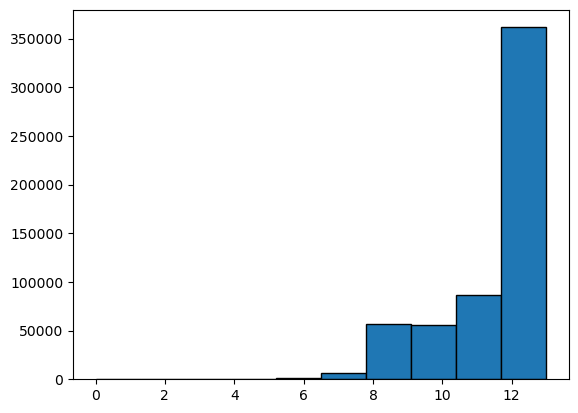

In [300]:
plt.hist(clean_data['year'],edgecolor='black')
plt.show()

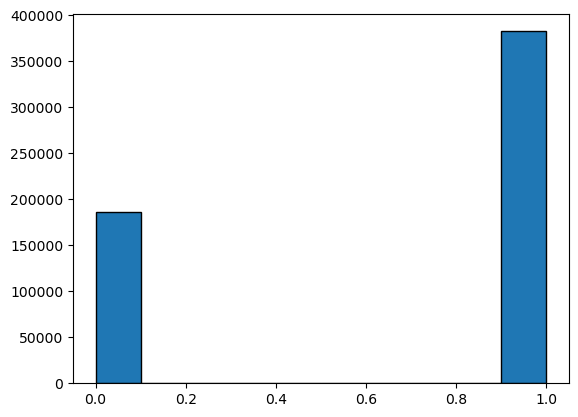

In [301]:
plt.hist(clean_data['hour'],edgecolor='black')
plt.show()

# turn them into torch dataset

In [302]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [303]:
p=torch.tensor(90,dtype=torch.long)

In [396]:
class Mydataset(Dataset):
    def __init__(self,data):
        super().__init__()
        self.data=data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        #element to extract
        item=self.data.iloc[idx]
        
        return {
            "product_id":torch.tensor([item['ProductId']],dtype=torch.long).to(device),
            "user_id":torch.tensor([item['UserId']],dtype=torch.long).to(device) ,
            "year":torch.tensor([item['year']],dtype=torch.long).to(device) ,
            "month":torch.tensor([item['month']],dtype=torch.long).to(device) ,
            "day_of_week":torch.tensor([item['day_of_week']],dtype=torch.long).to(device) ,
            "hour":torch.tensor([item['hour']],dtype=torch.long).to(device) ,
            "recomended":torch.tensor([item['Recomended']],dtype=torch.float).to(device)
        }

## loading the torch dataset format

In [397]:
#trainig dataset
train_dataset=Mydataset(train)
test_dataset=Mydataset(test)

In [398]:
print(train_dataset)
print(test_dataset)

# turning it into torch dataloader

In [399]:
#making the train dataloader
train_dataloader=DataLoader(
    dataset=train_dataset,
    batch_size=32
)

#making test dataloader
test_dataloader=DataLoader(
    dataset=test_dataset,
    batch_size=32
)

In [400]:
# acessing elements of the dataloader
for batch in train_dataloader:
    print(batch['product_id'].shape)
    print(batch['user_id'].shape)
    break

torch.Size([32, 1])
torch.Size([32, 1])


# model package importing

In [441]:
import sys
sys.path.append('C:/Users/nebiy/Documents/recommendation_system/tiny_recommendation/jupyter_notes/trial.py')
from trial import WideDeep,WD_Config

In [442]:
config=WD_Config()
config.num_product=clean_data['ProductId'].nunique()
config.num_users=clean_data['UserId'].nunique() 
config.num_year=clean_data["year"].nunique()
config.num_time_day=clean_data["hour"].nunique()
config.num_month=clean_data['month'].nunique()+1   #since in this column it start from 1
config.num_day_week=clean_data["day_of_week"].nunique()
config.embedding_dim=100

In [443]:
print(config)

WD_Config(num_product=74257, num_users=256042, num_day_week=7, num_month=13, num_time_day=2, num_feature=6, embedding_dim=100, num_year=14)


In [444]:
model=WideDeep(config)

# setup the config of the model

In [445]:
clean_data["day_of_week"].value_counts()

day_of_week
2    87051
1    85986
0    85850
6    85360
3    79679
5    72791
4    71684
Name: count, dtype: int64

In [446]:
# config.num_product=clean_data['ProductId'].nunique()+1
# config.num_users=clean_data['UserId'].nunique() +1
# config.num_year=clean_data["year"].nunique()+1
# config.num_time_day=clean_data["hour"].nunique()+1
# config.num_month=clean_data['month'].nunique()+1
# config.num_day_week=clean_data["day_of_week"].nunique()+1
# config.embedding_dim=100

In [447]:
model=model.to(device)

In [448]:
optim=torch.optim.AdamW(model.parameters(),lr=0.01)  #the deep component
loss_fn=torch.nn.BCELoss() 

# lets debug some stuff with data and model

In [449]:
# lets access 10 elements from one batch
for batch in train_dataloader:
    product_id=batch["product_id"]
    user_id=batch["user_id"]
    year=batch["year"]
    month=batch["month"]
    day_of_week=batch["day_of_week"]
    hour=batch["hour"]
    recomended=batch["recomended"]
    
    print(product_id.size(0))
    print(user_id.shape)
    print(year.shape)
    print(recomended.shape)
    print(month.shape)
    print(year.shape)
    print(day_of_week.shape)

    break

32
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


# train my model

In [450]:
# extraxt one batch 
for batch in train_dataloader:
    one_batch=batch
    break

In [451]:
# reco=batch['recomended']
# print(reco)

In [452]:
#lets start the training
n_epoch=100
for epoch in range(n_epoch):
    #getting the shape right
    product_id=one_batch['product_id']
    user_id=one_batch['user_id']
    year=one_batch['year']
    month=one_batch['month']
    day_of_week=one_batch['day_of_week']
    hour=one_batch['hour']
    recomended=one_batch['recomended']

    #changing the value of the recomended
    recomended=recomended.float()

    #print some of the values
    # print(product_id.shape)
    # print(user_id.shape)
    # print(year.shape)
    # print(month.shape)
    # print(day_of_week.shape)
    # print(hour.shape)
    
    #feed forward model
    model_pred=model(
        product_id,
        user_id,
        year,
        month,
        day_of_week,
        hour
    )

    #compare differnce between target and actual
    #print(model_pred.shape)
    #print(recomended.shape)
    
    #for numerical stability lets use
    epsilon=1e-7
    model_pred=torch.clamp(model_pred,min=epsilon,max=1-epsilon)

    #check out the out put after each epoch
    print(f"model-pred:{model_pred}")
    print(f"actual-val:{recomended}")
    
    #calculate the loss
    loss=loss_fn(recomended,model_pred)
   
    
    #zero grad
    optim.zero_grad()
    loss.backward()
    optim.step() #update the gradient 
    
    
    #display the loss every 5 epoch
    if(epoch%10==0):
        print(f"the loss is {loss.item()}")

model-pred:tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<ClampBackward1>)
actual-val:tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.